# Headphones-Speakers Standing Respiration
This jupyter notebook walkes through the analysis of respirations recorded from participants in the Headphones-Speakers study. 

Participants stook still (comfortably) while wearing sensors and motion capture markers and hearing sequences of silence and musical stimuli. The experiment was run as part of Agata Zelechowska's PhD research with Victor Evaristo Gonzalez Sanchez and supervised by Alexander Refsum Jensenius. 

The respiration measurements were recorded with an X sensor. This unit has some challenges with sampling quality and time locking. The recorded signals have already been synched and resampled in alignment (linear) with the motion capture recordings during the same stimulus presentations.

This document:
    
    1) extracts breath timing information from the recorded respiration sequences
    2) codes exerpts of respiration according the experiment factors
    3) evaluates breathwise respiration features for each excerpt/conditions
    4) evaluates the statistical relevance of conditions on the respiration features
    5) refines the temporal model of effect on those significant factors
    6) evaluates reliability of respiration features as indicators of conditions.

# 0) import libraries, define functions

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis as act # 

In [4]:
# import respy functions from respy.py file
%load_ext autoreload
%autoreload 1
%aimport respy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#     1) extracts breath timing information from the recorded respiration sequences


In [5]:
# extract stimulus intervals
os.chdir('/Users/finn/Documents/Resp/RITMO/Heaphones_Speakers/')
stim_sequence = pd.read_csv('StimSequences.csv')
print(stim_sequence.columns)
stim_sequence=stim_sequence.set_index('Participant')

# identify subset of participants to include, based on data quality
A = stim_sequence.loc[stim_sequence['filter_35_headphones_or_speakers']==1]
A = A.loc[A['Resp_signal']==1]
participants = A.index.values
print(participants)
stim_sequence=stim_sequence.loc[participants,:]

Index(['S1_1', 'S1_2', 'S1_3', 'S1_4', 'S1_5', 'S1_6', 'S2_1', 'S2_2', 'S2_3',
       'S2_4', 'S2_5', 'S2_6', 'Hp/Sp first',
       'filter_35_headphones_or_speakers', 'filter_34_who_moves_to_music',
       'Participant_number', 'Hp_Sp_first_12', 'Resp_signal', 'Participant'],
      dtype='object')
['S09' 'S10' 'S11' 'S12' 'S13' 'S14' 'S16' 'S17' 'S18' 'S19' 'S21' 'S23'
 'S24' 'S25' 'S26' 'S27' 'S28' 'S29' 'S30' 'S31' 'S32' 'S33' 'S34' 'S35'
 'S36' 'S38' 'S39' 'S41']


<AxesSubplot:xlabel='Time s'>

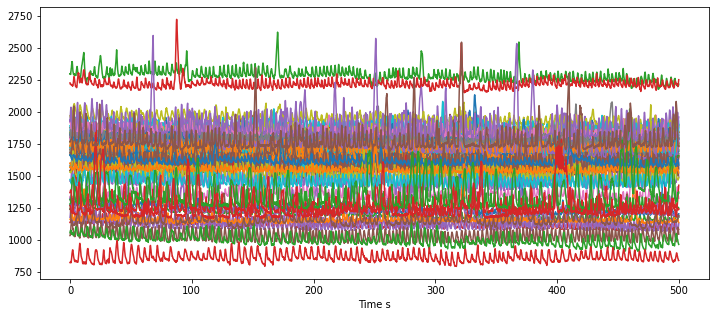

In [6]:
# pull in and organise recordings across the experiment

os.chdir('/Users/finn/Documents/Resp/RITMO/Heaphones_Speakers/Breathing_Data/')
sf = 10
df = pd.DataFrame() 
df['Time s'] = np.arange(5001)/sf
df=df.set_index('Time s')
folders = os.listdir()
folders = sorted(folders)
parts = []
sess = []
for fold in participants: # exclude participants excluded in other studies
    os.chdir(fold)
    files = os.listdir()
    files = sorted(files)
    r = 1
    bf = pd.DataFrame()
    bf['Time s'] = df.index
    bf=bf.set_index('Time s')
    for f in files:
        if f.startswith('S'): # now using the motion capture aligned data 
            if f.endswith('.csv'):
                a = pd.read_csv(f, header=None)
                a['Time s'] = np.arange(len(a))/sf
                a=a.set_index('Time s')
                parts.append(fold)
                sess.append('S'+str(r))
                colName = fold+'-'+str(r)
                r += 1
                df[colName] = a
                bf[colName] = a
    os.chdir('..')

respRecs = [np.array(sess),np.array(parts)]
index = pd.MultiIndex.from_tuples(list(zip(*respRecs)), names=['Session', 'Participants'])
idx = pd.IndexSlice
RespRecs = pd.DataFrame(df.values,index = df.index, columns=index)

RespRecs.plot(figsize=(12,5),legend=False)
#RespRecs.loc[:df.index[5]]

<AxesSubplot:xlabel='Time s'>

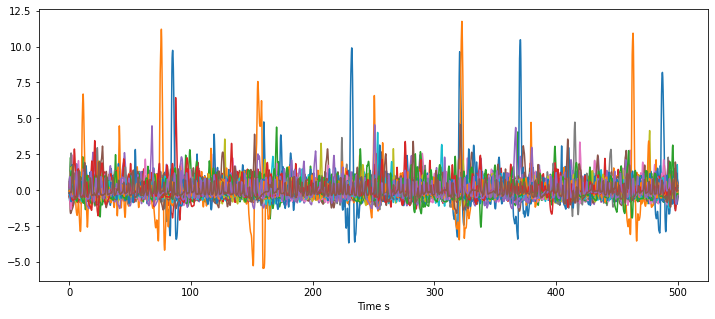

In [7]:
# as there are two recordings per person that presumably were taken with the same set up, 
# normalisation of respiration belt values should take values from both
# here we normalise by median inspiration depth across all recordins from each person
#  just in case there is a systematic effect of condition or order on stretch values.
RespNorm=RespRecs.copy()
for part in participants:
    br = pd.DataFrame()
    for sess in ['S1','S2']:
        sig = RespRecs.loc[:,idx[sess,part]]
        br = br.append(respy.Breath_Features(sig,scalingfactor=1),ignore_index=True)
    for sess in ['S1','S2']:
        sig = RespRecs.loc[:,idx[sess,part]]
        newSig=respy.respnormed(sig,scaling=1/br['Depth'].median())
        RespNorm.loc[:,idx[sess,part]]=newSig.iloc[:,0]
RespNorm.plot(figsize=(12,5),legend=False)

# from here, these signals are normalised and filtered so scaling = 1, filtered = True

In [8]:
# interpret the stimulus order to get recording specific time intervals per exposure
    # os.chdir('/Users/finn/Documents/Resp/RITMO/Heaphones_Speakers/')
    # stim_sequence = pd.read_csv('StimSequences.csv')
    
# stimulus times per participant
df_times = pd.DataFrame()

#stimulus_dur= [30, 48.7, 47.9, 47.5, 47.9, 47.6, 47.9] 
stim_names = ['Rest','Rhythm','Andre','Metronome','Neelix1','Neelix2','Pysh']
stimulus_dur = {'Rest':30,'Rhythm':48.7,'Andre':47.9,'Metronome':47.5,'Neelix1':47.9,'Neelix2':47.6,'Pysh':47.9} # seconds, stimulus[0] is the rest period duration

for row in stim_sequence.iterrows():
    seq=row[1]
    ts = [stimulus_dur['Rest']]
    tl = np.zeros(24)
    for i in range(6):
        stim_n = seq[i]
        stim_name = stim_names[stim_n]
        stim_o = i
        if i>0:
            ts.append(ts[-1]+stimulus_dur['Rest'])
        tl[(stim_n-1)*2] = ts[-1]
        ts.append(ts[-1]+stimulus_dur[stim_name])
        tl[(stim_n*2)-1] = ts[-1]
    ts.append(stimulus_dur['Rest'])
    for i in range(6): 
        stim_n = seq[i+6]
        stim_name = stim_names[stim_n] 
        stim_o = i+6
        if i>0:
            ts.append(ts[-1]+stimulus_dur['Rest'])
        tl[(stim_n*2)+10] = ts[-1]
        ts.append(ts[-1]+stimulus_dur[stim_name])
        tl[(stim_n*2)+11] = ts[-1]
    
    df_times = df_times.append(pd.Series(np.round(tl,1)), ignore_index=True)

stimConds = [np.array(['S1','S1','S1','S1','S1','S1','S1','S1','S1','S1','S1','S1','S2','S2','S2','S2','S2','S2','S2','S2','S2','S2','S2','S2']),
         np.array(['Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh','Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh'])]
index = pd.MultiIndex.from_tuples(list(zip(*stimConds)), names=['Session', 'Stimulus'])

stimOnsets = pd.DataFrame(df_times.values,index=stim_sequence.index, columns=index)

<AxesSubplot:xlabel='Time s'>

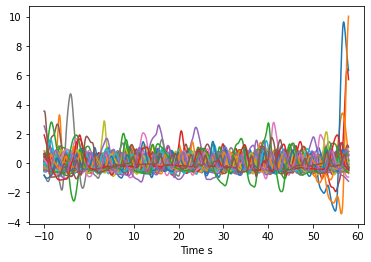

In [9]:
# example extraction of responses corresponditing to a specific stimulus
stim = 'Andre'
buff = 10
dt = pd.DataFrame()
dt['Time s'] = np.round((np.arange(((stimulus_dur[stim]+2*buff)*sf)+1)/sf)-buff,3)
dt=dt.set_index('Time s')

for part in participants:
    for sess in ['S1','S2']:
        # signal, stimulus times, recording condtions
        sig = RespNorm.loc[:,idx[sess,part]]
        
        onsets = stimOnsets.loc[idx[part],idx[sess,:]]
        #pdets = stim_sequence.loc[part]
        sig.index = np.round(sig.index-onsets.loc[idx[sess],idx[stim]],3) # align index
        dt[part+'-'+sess] = sig.loc[-buff:stimulus_dur[stim]+buff]

dt.plot(legend=False)

# 2) codes exerpts of respiration according the experiment factors


In [10]:
# now build a database of variables per exposure, 
# independent conditions and depenedent features of respiration

#this cell can evaluate the median breath values per features or the std per features, 
  #or, very important here, sequential stability (abs median on first order difference)
feat_means = pd.DataFrame(columns=['Stimulus', 'Sound', 'Participant', 'Session', 'Condition','Depth','Insp_T','Period_T','Exp_T','IE_Ratio','Insp_V','Exp_V','Depth_sdm','Insp_T_sdm','Period_T_sdm','Exp_T_sdm','IE_Ratio_sdm','Insp_V_sdm','Exp_V_sdm'])

# Per recording, extract respirations, breath features, and save statistics with all conditions in new dataframe
stim_names = ['Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh','Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh']
buff = 0
heard_op = ['','Headphones','Speakers']


for part in participants:
    dets = stim_sequence.loc[part]
    con = dets['Hp_Sp_first_12']
    heard = dets['Hp/Sp first']
    for sess in ['S1','S2']:
        if sess == 'S2':
            con=3-con
            heard = heard_op[con]
        # signal, stimulus times, recording condtions
        sig = RespNorm.loc[:,idx[sess,part]]
        onsets = stimOnsets.loc[idx[part],idx[sess,:]]
        
        Breaths = respy.Breath_Features(sig,filtered=True)
        Breaths = Breaths.set_index('In')
        Breaths = Breaths.drop(columns=['Ex'])
        
        for stim in stim_names:
            stim_on = onsets.loc[idx[sess],idx[stim]]
            if stim.startswith('Rest'):
                dur = 30
                sounding = 'Off'
            else:
                #dur = 25
                dur = stimulus_dur[stim]
                sounding = 'On'
            v = Breaths.loc[stim_on-buff:stim_on+dur+buff]
            
            j = pd.Series({'Stimulus':stim,'Sound':sounding, 'Participant':part,'Session': sess,'Condition':heard})
            j=j.append(v.median())
#             j=j.append(v.std())
            v = v.rename(columns={'Depth':'Depth_sdm','Insp_T':'Insp_T_sdm','Period_T':'Period_T_sdm','Exp_T':'Exp_T_sdm','IE_Ratio':'IE_Ratio_sdm','Insp_V':'Insp_V_sdm','Exp_V':'Exp_V_sdm'})
            j=j.append(abs(v.diff()).median())
            feat_means= feat_means.append(j,ignore_index=True)

In [11]:
feat_means

,Stimulus,Sound,Participant,Session,Condition,Depth,Insp_T,Period_T,Exp_T,IE_Ratio,Insp_V,Exp_V,Depth_sdm,Insp_T_sdm,Period_T_sdm,Exp_T_sdm,IE_Ratio_sdm,Insp_V_sdm,Exp_V_sdm
0,Rhythm,On,S09,S1,Speakers,1.007628,0.9,3.20,2.30,0.392857,1.074588,0.454402,0.246754,1.500000e-01,0.40,0.20,0.036114,0.156068,0.059423
1,Rest_Rhythm,Off,S09,S1,Speakers,0.974418,1.0,3.45,2.50,0.403704,0.970040,0.392683,0.167885,1.000000e-01,0.40,0.30,0.041667,0.058066,0.055746
2,Andre,On,S09,S1,Speakers,1.288707,1.1,3.60,2.60,0.423274,1.161837,0.511280,0.096019,1.000000e-01,0.20,0.20,0.059829,0.087290,0.028535
3,Rest_Andre,Off,S09,S1,Speakers,1.001981,0.9,3.45,2.55,0.400198,1.019715,0.397751,0.289510,5.684342e-14,0.40,0.40,0.062937,0.119464,0.072314
4,Metronome,On,S09,S1,Speakers,1.153725,1.0,3.20,2.20,0.450000,1.153725,0.533089,0.203582,5.000000e-02,0.20,0.20,0.053313,0.113325,0.054850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,Rest_Neelix1,Off,S41,S2,Speakers,0.599197,0.8,3.50,2.40,0.310345,0.827501,0.256811,0.222987,2.000000e-01,1.30,1.35,0.103784,0.191731,0.142884
1340,Neelix2,On,S41,S2,Speakers,0.890029,0.9,3.30,2.40,0.409091,1.014323,0.367394,0.174426,1.000000e-01,0.35,0.40,0.124674,0.092027,0.117854
1341,Rest_Neelix2,Off,S41,S2,Speakers,0.721479,0.9,3.70,2.80,0.428571,0.782640,0.263788,0.290909,1.000000e-01,1.55,1.10,0.146078,0.251565,0.402441
1342,Pysh,On,S41,S2,Speakers,0.656172,0.8,3.65,2.90,0.271264,0.829529,0.225055,0.480111,3.000000e-01,0.90,0.50,0.125479,0.231304,0.197717


#  3) evaluates the statistical relevance of conditions on the respiration features


In [10]:
# dependent variables to be considered against experiment factors
#defeats = ['Depth','Insp_T','Period_T','Exp_T','IE_Ratio','Insp_V','Exp_V']
defeats = ['Depth','Insp_T','Period_T','Exp_T','IE_Ratio','Insp_V','Exp_V','Depth_sdm','Insp_T_sdm','Period_T_sdm','Exp_T_sdm','IE_Ratio_sdm','Insp_V_sdm','Exp_V_sdm']
defeats.sort()    
# independent variables to be considered ['Sound','Stimulus','Condition','Session']
    # The relationship between Sound and Stimulus complicates evaluation
    # When stimuli are playing, Sound is on, when resting (6 rest conditions) Sound is off

# for the sake of computation we first evaluate on three factors
bfactors = ['Sound','Condition','Session']

# then exclude the rest conditions to evaluate between stimuli in conjuction

In [11]:
# pinguine can't do repeated measures on 3+ factors, so we use regular anova
# if there are promising interactions, we can see if they survive when 
# participant is added to the model. If the effect is real, it should strengthen!

bfactors = ['Sound','Condition','Session']
for col in defeats: 
    aov = pg.anova(dv=col, between=bfactors, data=feat_means)
    print('\n\n' + col + ' medians for factors: ' + str(bfactors))
    print(aov)



Depth medians for factors: ['Sound', 'Condition', 'Session']
                        Source         SS      DF        MS          F  \
0                        Sound   1.020430     1.0  1.020430  19.454559   
1                    Condition   1.060758     1.0  1.060758  20.223422   
2                      Session   0.543683     1.0  0.543683  10.365362   
3            Sound * Condition   0.000619     1.0  0.000619   0.011806   
4              Sound * Session   0.094187     1.0  0.094187   1.795680   
5          Condition * Session   0.544631     1.0  0.544631  10.383424   
6  Sound * Condition * Session   0.011017     1.0  0.011017   0.210045   
7                     Residual  70.075807  1336.0  0.052452        NaN   

      p-unc       np2  
0  0.000011  0.014353  
1  0.000007  0.014912  
2  0.001315  0.007699  
3  0.913492  0.000009  
4  0.180463  0.001342  
5  0.001302  0.007712  
6  0.646807  0.000157  
7       NaN       NaN  


Depth_sdm medians for factors: ['Sound', 'Condition'



Period_T_sdm medians for factors: ['Sound', 'Condition', 'Session']
                        Source          SS      DF         MS          F  \
0                        Sound   16.942567     1.0  16.942567  36.249321   
1                    Condition    1.331317     1.0   1.331317   2.848408   
2                      Session    1.595007     1.0   1.595007   3.412584   
3            Sound * Condition    0.105365     1.0   0.105365   0.225432   
4              Sound * Session    0.000067     1.0   0.000067   0.000143   
5          Condition * Session    3.470900     1.0   3.470900   7.426134   
6  Sound * Condition * Session    0.282924     1.0   0.282924   0.605328   
7                     Residual  624.432917  1336.0   0.467390        NaN   

          p-unc           np2  
0  2.239966e-09  2.641599e-02  
1  9.169790e-02  2.127506e-03  
2  6.492202e-02  2.547822e-03  
3  6.350095e-01  1.687080e-04  
4  9.904516e-01  1.072401e-07  
5  6.512237e-03  5.527758e-03  
6  4.366902e-01  4.52

Factors on dependent variables (numerous and related) as assessed on 3 factor anovas:

1) Depth: Medians of this feature shows the strongest effect of condition (M), with Sound as well, and a small effect of session, and the first suggestion of interact between conditions and session, ConSess (S). Sequential variability affected most by sound (M) with again a little effect of condition and interaction ConSess

2) Inspiration Time: on Medians, Sound is a strong effect. Sequential difference Sound is medium, and ConSess small

3) Inspiration Velocity: on the Medians, Sound, Conditionn and ConSess have small effects. Seq with small sound effect.

4) Expiration Time: on Medians, Sound has a large effect, condition and consess small effects. Seq with medium effect of sound.

5) Expiration Velocity: On the median, Sound effect is medium

6) I/E ratio: only effect is sound (M) on medians

7) Period T: Medians strongly effected by Sound (consistent with Insp and Exp), small effect of session, sequential difference shows medium effect of Sound and some small consess interaction.

In sum, Sound is a very strongest factor for medians and particularly for sequential differences, but features using depth (relative) show some effect of condition. Also persistent impacts of condition/session interactions which are not large, but express in many feature medians and sequential differences. 

As such, depth and condition are important to look at, as well as the total affect of Sound on respiration durations (and related velocity). Condition/session interaction worth investigating with skepticism.

The experiment design, however, is repeated measures for most factors, meaning that participant models can be added to explain variance and put the condition effects in context

When considered in repeated measures analysis:

    1 - Sound: shows effect for most features, strongest for period time medians.
    2 - Condition: as a single factors, slight possible effect of depth sequential differences. This is really odd, how the factor's main effect disapears with repeated measures (median depth.) 
    3 - Session: no effect, save a slight blip for inspriation velocity. Not convincing.
    4 - Stimulus (Sound ON): Exp_T means small effect when corrected, Insp T means, Insp V means, Period T. F max 5
    
When considered in repeated measures with two factors (limited here by coverage):
    
    1 - Sound & Condition: condition comes out on sequential differents on Depth, but not medians. No interactions
    2 - Sound & Session: session comoes on on sequential difference in Inspiration Velocity, not medians.No interaction
    3 - 'Stimulus','Session': Only stimulus effects
    4 - 'Stimulus','Condition': condition comes out on IE ratio (slight). no interaction. otherwise just stimulus effects.

Session and Condition are more complicated to look at because they are not jointly covered with repeated measures. However, because they show little to no effect elsewhere when participants are included in the model, it seems unlikely that their interactions are robust.

In [12]:
bfactors = ['Stimulus','Condition']
subfeat = feat_means[feat_means.Sound == 'On'] # data=subfeat data=feat_means
for col in defeats: 
    aov = pg.rm_anova(dv=col, within=bfactors,
                      subject='Participant', data=subfeat, detailed=True,
                      effsize="ng2")
    print('\n\n' + col + ' means for factors: ' + str(bfactors))
    print(aov)



Depth means for factors: ['Stimulus', 'Condition']
                 Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              Stimulus  0.196747      5    135  0.039349  1.202344  0.311455   
1             Condition  0.252529      1     27  0.252529  1.099228  0.303730   
2  Stimulus * Condition  0.059148      5    135  0.011830  0.434500  0.823861   

   p-GG-corr       ng2       eps  
0   0.314593  0.012570  0.709404  
1   0.303730  0.016076  1.000000  
2   0.779782  0.003812  0.784443  


Depth_sdm means for factors: ['Stimulus', 'Condition']
                 Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              Stimulus  0.302286      5    135  0.060457  1.825666  0.111883   
1             Condition  0.089373      1     27  0.089373  2.691692  0.112473   
2  Stimulus * Condition  0.056653      5    135  0.011331  0.464890  0.801832   

   p-GG-corr       ng2       eps  
0   0.131821  0.019580  0.771196  
1   0.112473  0.005870  1.0000

In [13]:
# bfactors = ['Condition','Session']
#  # can't fully repeated measures on condition and session so we look at avreages without participant model
# for col in defeats: 
#     aov = pg.anova(dv=col, between=bfactors, data=feat_means)
#     print('\n\n' + col + ' means for factors: ' + str(bfactors))
#     print(aov)

To quantify these factors in relevant terms, we can evaluate the feature means and standard deviations. 

In [14]:
# looking for gross trends, without participant means

# look first at interaction of sound and session by extracting their statistics
# bfactors = ['Sound','Session'] 
# The effect  on depth is small, looks like difference for sound condition is stronger in first 
# session, relaxed towards mean in second. Not so substantial. 


bfactors = ['Sound','Session','Condition']

Indiv_factors = []

for bfactor in bfactors:
    Ind_factors=pd.DataFrame()
    bfvalues = feat_means[bfactor].unique()

    for part in participants:
        df_means = pd.DataFrame()
        partfeat = feat_means[feat_means['Participant'] == part]

        for val in bfvalues:
            subfeat = partfeat[partfeat[bfactor] == val]
            m = pd.Series({bfactor:val,'Number':len(subfeat),'Participant': part})
            mm=m.append(subfeat[defeats].mean())
            df_means= df_means.append(mm,ignore_index=True)

        #print(df_means)
        a = df_means.loc[:,defeats].diff().reset_index()
        Ind_factors = Ind_factors.append(a.loc[1],ignore_index=True)
    Indiv_factors.append(Ind_factors)
    #df_means

#Indiv_factors

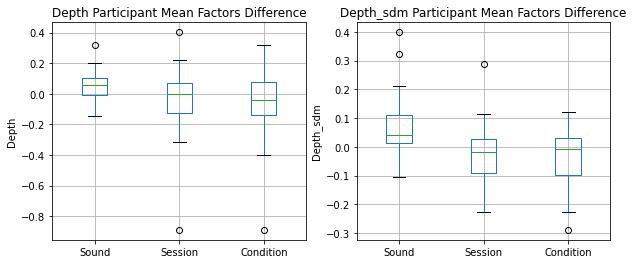

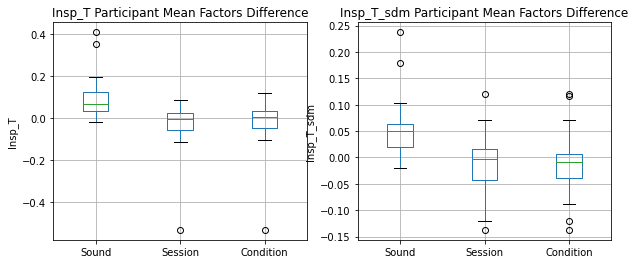

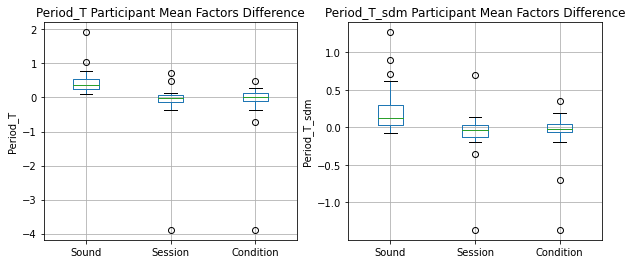

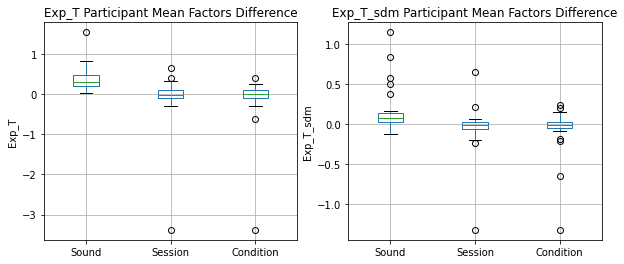

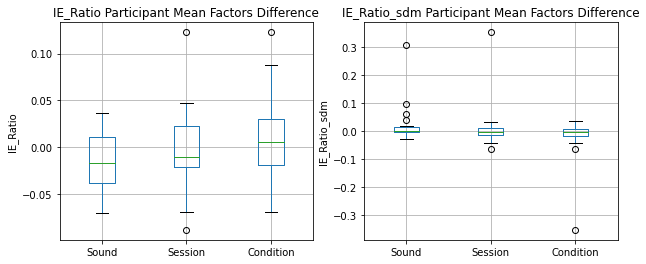

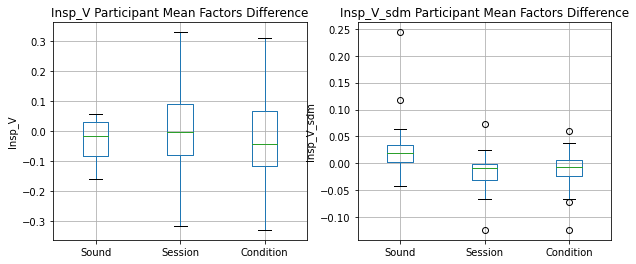

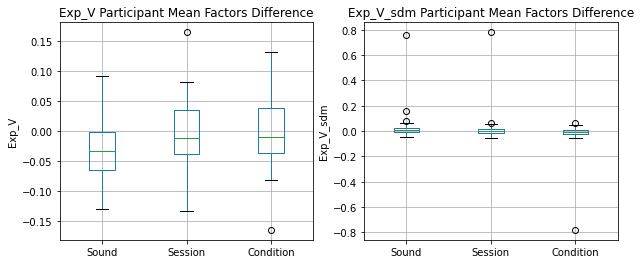

In [15]:
bfactors = ['Sound','Session','Condition']

for col in ['Depth','Insp_T','Period_T','Exp_T','IE_Ratio','Insp_V','Exp_V']:
    fig = plt.figure(figsize=(10,4))
    
    In_Feat_Col = pd.DataFrame()
    for i in range(len(bfactors)):
        Ind_factors = Indiv_factors[i]
        In_Feat_Col[bfactors[i]]=Ind_factors[col].values
    ax = fig.add_subplot(121)
    In_Feat_Col.plot.box(ax=ax,)#
    plt.grid()
    plt.title(col + ' Participant Mean Factors Difference')
    plt.ylabel(col)
    
    col = col+'_sdm'
    In_Feat_Col = pd.DataFrame()
    for i in range(len(bfactors)):
        Ind_factors = Indiv_factors[i]
        In_Feat_Col[bfactors[i]]=Ind_factors[col].values
    ax = fig.add_subplot(122)
    In_Feat_Col.plot.box(ax=ax,)#
    plt.grid()
    plt.title(col + ' Participant Mean Factors Difference')
    plt.ylabel(col)

    plt.savefig('/Users/finn/Documents/Resp/RITMO/Heaphones_Speakers/Breathing_Data/Plots/Indiv_Factor_Diff_' + col + '.png') 
#     In_Feat_Col.plot.hist(alpha=0.5,bins=50,figsize=(10,2.5))    

Spelled out more plainly, the features that distinguish 

the Sound factor (75th percentile on participant means): 
'Insp_T' M Sq,'Period_T' M Sq,'Exp_T M Sq', ('Depth' M Sq,'Insp_V' Sq, 'Exp_V' M )

the Condition factor (75th percentile on participant means): 

the Session factor (75th percentile on participant means): 
('Insp_V' Sq)



In [16]:
# looking for gross trends in participant means, between stimuli
bfactor = 'Stimulus'
stimuli = ['Metronome', 'Rhythm', 'Andre','Neelix1', 'Neelix2', 'Pysh']
bfvalues = feat_means[bfactor].unique()

Indiv_factors = []

Ind_factors=pd.DataFrame()


for stim in stimuli:
    Indiv_factors.append(Ind_factors)

for part in participants:
    df_means = pd.DataFrame()
    partfeat = feat_means[feat_means['Participant'] == part]

    for stim in bfvalues: # average across all 12 intervals, including rests
        subfeat = partfeat[partfeat[bfactor] == stim]
        m = pd.Series({bfactor:stim,'Number':len(subfeat),'Participant': part})
        mm=m.append(subfeat[defeats].mean())
        df_means= df_means.append(mm,ignore_index=True)

    df_means[defeats] = df_means[defeats] - df_means[defeats].mean()

    for i in range(len(stimuli)): # presever specifically those that are stimuli
        stim = stimuli[i]
        a=df_means[df_means[bfactor]==stim]
        Ind_factors = Indiv_factors[i].copy() 
        Ind_factors = Ind_factors.append(a,ignore_index=True)
        Indiv_factors[i] =Ind_factors
    #Indiv_factors.append(Ind_factors)
    #df_means

#Indiv_factors

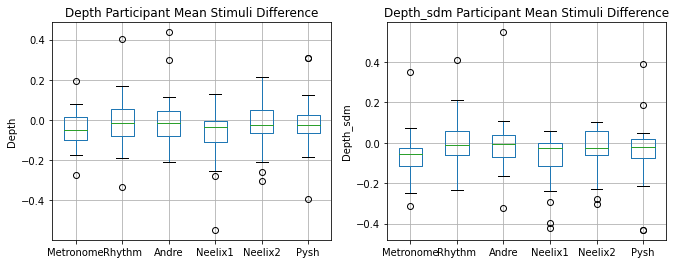

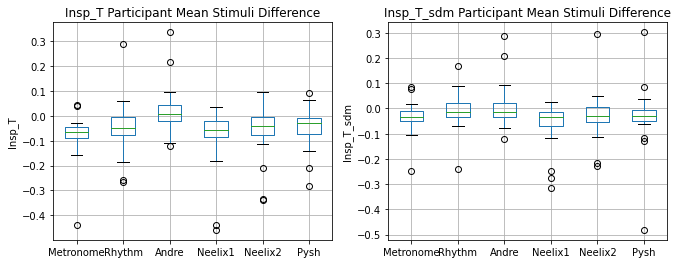

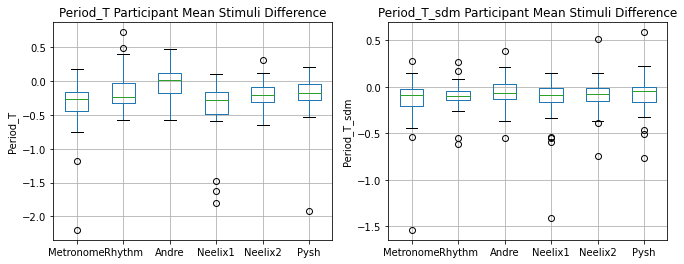

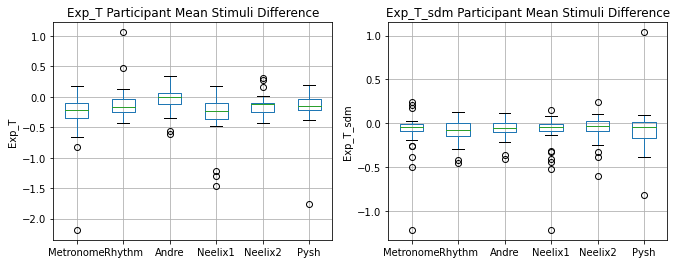

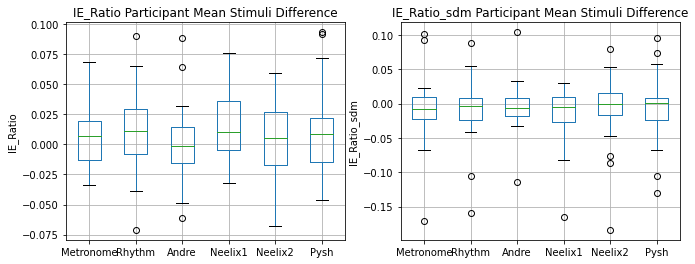

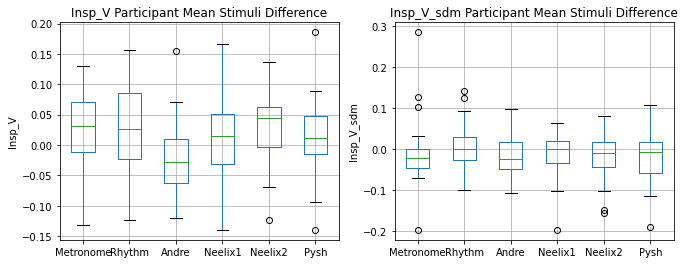

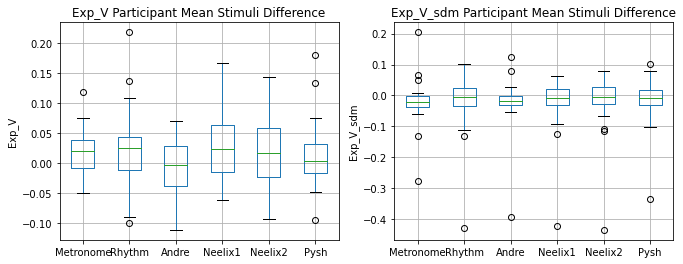

In [17]:
bfactors = ['Sound','Session','Condition']

stimuli = ['Metronome', 'Rhythm', 'Andre','Neelix1', 'Neelix2', 'Pysh']

for col in ['Depth','Insp_T','Period_T','Exp_T','IE_Ratio','Insp_V','Exp_V']:
    fig = plt.figure(figsize=(11,4))
    
    In_Feat_Col = pd.DataFrame()
    for i in range(len(stimuli)):
        Ind_factors = Indiv_factors[i]
        In_Feat_Col[stimuli[i]]=Ind_factors[col].values
    ax = fig.add_subplot(121)
    In_Feat_Col.plot.box(ax=ax,)#
    plt.grid()
    plt.title(col + ' Participant Mean Stimuli Difference')
    plt.ylabel(col)
    
    col = col+'_sdm'
    In_Feat_Col = pd.DataFrame()
    for i in range(len(stimuli)):
        Ind_factors = Indiv_factors[i]
        In_Feat_Col[stimuli[i]]=Ind_factors[col].values
    ax = fig.add_subplot(122)
    In_Feat_Col.plot.box(ax=ax,)#
    plt.grid()
    plt.title(col + ' Participant Mean Stimuli Difference')
    plt.ylabel(col)

    plt.savefig('/Users/finn/Documents/Resp/RITMO/Heaphones_Speakers/Breathing_Data/Plots/Indiv_Stimuli_Diff_' + col + '.png') 
#     In_Feat_Col.plot.hist(alpha=0.5,bins=50,figsize=(10,2.5))    

From this we can take a number of features of the list of what is worth investigating.

The features that distinguish between stimuli (Pairwise): Insp_T M, Period T M, Exp T M, Insp V M

What is the distinction of Andre? the differences in impact is from the outset. Is this about timbre, rhythm, or tempo?

# 5) refines the temporal model of effect on those significant factors
When do these respiration changes to sound get expressed? Looking at breathwise features in time with time series medians and activity analysis to describe concentrations of effect.

In [210]:
def activityCount(Data,FrameSize,HopSize,Thresh,actType):
    ''' def activityCount(Data,FrameSize,HopSize,Thresh,actType)
    (Time,Series,FrameSize,HopSize,Thresh,option)

     function to identify the occurances and popularity of activity 
     events (specified by 'option' and 'Thresh') across the columns
     of Data time series over frames of size FrameSize and 
     intervals of Hopsize. Columns are treated as signals to be 
     translated into point processes.
     
     Inputs: Data - an pandas dataframe with index of time in the same units
                    as FrameSize and Hopsize and columns of signal measurements
             FrameSize - the interval of signal actions are to be evaluated over
             HopSize - the spacing between these intervals of signal (can be smaller than FrameSize)
             Thresh - a minimum value (scalar) for events measured in frames
             actType - a string specifying the type of signal event to detect
                     one of {'Inc','Dec','Change'} (so far)
     Outputs: Acts - a pandas dataframe with index 'Time' of time points (centres of frames)
                     columns for every column of signal in Data (carries names)
                     final column ['Total'] that reports the ratio of signals active per frame
     Version 5.0, first in Python 3
     Finn Upham 2020 12 07
     '''

    Time = Data.index
    cols = Data.columns
    
    newTime = np.arange(FrameSize/2+Time[0],Time[-1],HopSize)
    Acts = pd.DataFrame()
    Acts['Time']=newTime
    Acts=Acts.set_index('Time')

    # for increases
    if actType == 'Inc':
        for col in cols:
            f = interp1d(Time,Data[col], kind='nearest',fill_value='extrapolate')
            a=f(newTime+FrameSize/2)-f(newTime-FrameSize/2)
            a[a>=Thresh] = 1
            a[a<Thresh] = 0
            Acts[col]=a
    if actType == 'Dec':
        for col in cols:
            f = interp1d(Time,Data[col], kind='nearest',fill_value='extrapolate')
            a=f(newTime+FrameSize/2)-f(newTime-FrameSize/2)
            a[a>-Thresh] = 0
            a[a<=-Thresh] = 1
            Acts[col]=a 
    if actType == 'Change':
        for col in cols:
            f = interp1d(Time,Data[col], kind='nearest',fill_value='extrapolate')
            a=np.abs(f(newTime+FrameSize/2)-f(newTime-FrameSize/2))
            a[a>=Thresh] = 1
            a[a<Thresh] = 0
            Acts[col]=a    

    Acts['Total'] = Acts.sum(1)/len(cols) # ratio of signals active per frame
    return Acts


In [172]:
os.chdir('/Users/finn/Documents/Resp/Jupiter_resp/figures/')


In [211]:
# evaluate timline of effects on stimuli 

buff =20
stim = 'Metronome'
feat = 'Period_T'
featCont = pd.DataFrame()
Treshes = {'Period_T': 0.5,'Exp_T':0.3,'Insp_T':0.1}
for part in participants:
    for sess in ['S1','S2']:
        sig = RespNorm.loc[:,idx[sess,part]]
        onsets = stimOnsets.loc[idx[part],idx[sess,:]]
        Breaths = respy.Breath_Continues_Features(sig,scaling=1,filtered=True,interp_style='previous')
        stim_on = onsets.loc[idx[sess],idx[stim]]
        if stim.startswith('Rest'):
            dur = 30
        else:
            dur = stimulus_dur[stim]
            sounding = 'On'
        v = Breaths.loc[stim_on-buff:stim_on+dur+buff,feat]
        v.index = np.round(v.index-stim_on,3)
        featCont[part + '_' + sess]=v


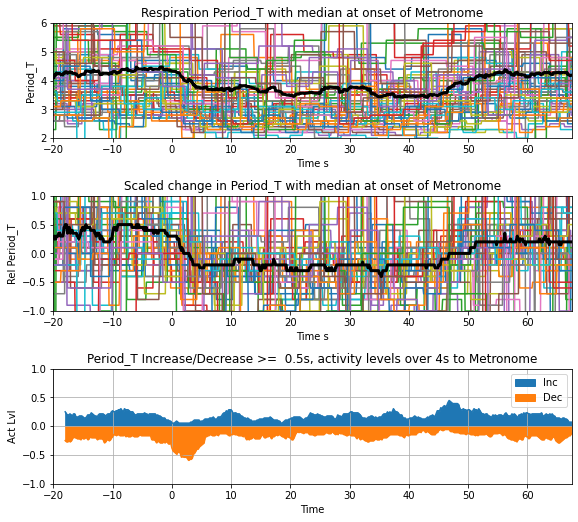

In [212]:
# changes in Period_T
Treshes = {'Period_T': 0.5,'Exp_T':0.3,'Insp_T':0.1}
fig = plt.figure(figsize=(9,8))
left, width = 0.1, 0.8
bottom, height = 0.1, 0.2
spacing = 0.1


subp = 0
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
# ax = fig.add_subplot(313)
FrameSize = 4 # seconds
HopSize = 0.2 # seconds
Thresh = 0.5 #Treshes[feat] # minimum
AC1 = activityCount(featCont,FrameSize,HopSize,Thresh,'Inc') 
AC2 = activityCount(featCont,FrameSize,HopSize,Thresh,'Dec')
AC = pd.DataFrame()
AC['Inc']=AC1['Total']
AC['Dec']=-AC2['Total']
AC.plot.area(ax=ax)

plt.grid()
plt.ylim(-1,1)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title(feat + ' Increase/Decrease >=  ' + str(Thresh)+ 's, activity levels over ' + str(FrameSize) + 's to ' + stim)
plt.ylabel('Act Lvl')
plt.legend(loc='upper right')

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
Shifted = featCont-featCont.median(0)
Shifted.plot(legend = False,ax=ax)
Shifted.median(1).plot(linewidth=3,color='k',ax=ax)
plt.ylim(-1,1)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title('Scaled change in ' + feat+ ' with median at onset of ' + stim)
plt.ylabel('Rel ' + feat)

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
plt.title('Respiration ' + feat + ' with median at onset of ' + stim)
featCont.plot(legend = False,ax=ax)
featCont.mean(1).plot(linewidth=3,color='k')
plt.ylim(2,6)
plt.ylabel(feat)
plt.xlim(featCont.index[0],featCont.index[-1])

plt.show()

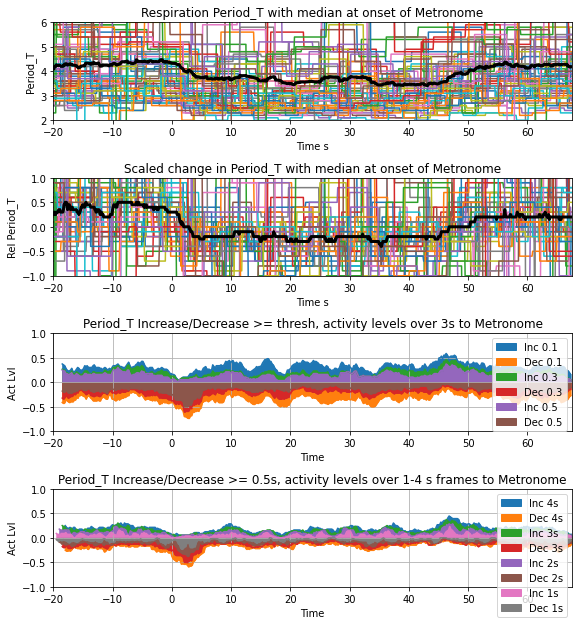

In [213]:
# changes in Period_T
Treshes = {'Period_T': 0.5,'Exp_T':0.3,'Insp_T':0.1}
fig = plt.figure(figsize=(9,8))
left, width = 0.1, 0.8
bottom, height = 0.1, 0.17
spacing = 0.1
thr = [0.1,0.3,0.5]
frm = [4,3,2,1]

subp = 0
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
# ax = fig.add_subplot(313)
for f in frm:
    FrameSize = f # seconds
    HopSize = 0.2 # seconds
    Thresh = thr[2]#Treshes[feat] # minimum
    AC1 = activityCount(featCont,FrameSize,HopSize,Thresh,'Inc') 
    AC2 = activityCount(featCont,FrameSize,HopSize,Thresh,'Dec')
    AC = pd.DataFrame()
    AC['Inc'+' '+str(f) + 's']=AC1['Total']
    AC['Dec'+' '+str(f) + 's']=-AC2['Total']
    AC.plot.area(ax=ax)

plt.grid()
plt.ylim(-1,1)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title(feat + ' Increase/Decrease >= ' + str(Thresh)+ 's, activity levels over 1-4 s frames to ' + stim)
plt.ylabel('Act Lvl')
plt.legend(loc='upper right')

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
# ax = fig.add_subplot(313)
for t in thr:
    FrameSize = 3 # seconds
    HopSize = 0.2 # seconds
    Thresh = t#Treshes[feat] # minimum
    AC1 = activityCount(featCont,FrameSize,HopSize,Thresh,'Inc') 
    AC2 = activityCount(featCont,FrameSize,HopSize,Thresh,'Dec')
    AC = pd.DataFrame()
    AC['Inc'+' '+str(t)]=AC1['Total']
    AC['Dec'+' '+str(t)]=-AC2['Total']
    AC.plot.area(ax=ax)

plt.grid()
plt.ylim(-1,1)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title(feat + ' Increase/Decrease >= thresh, activity levels over ' + str(FrameSize) + 's to ' + stim)
plt.ylabel('Act Lvl')
plt.legend(loc='upper right')

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
Shifted = featCont-featCont.median(0)
Shifted.plot(legend = False,ax=ax)
Shifted.median(1).plot(linewidth=3,color='k',ax=ax)
plt.ylim(-1,1)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title('Scaled change in ' + feat+ ' with median at onset of ' + stim)
plt.ylabel('Rel ' + feat)

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
plt.title('Respiration ' + feat + ' with median at onset of ' + stim)
featCont.plot(legend = False,ax=ax)
featCont.mean(1).plot(linewidth=3,color='k')
plt.ylim(2,6)
plt.ylabel(feat)
plt.xlim(featCont.index[0],featCont.index[-1])
plt.savefig(stim+feat+'_timecours_al.png',dpi = 400)
plt.show()

In [253]:
# evaluate timline of effects on stimuli 

buff =20
stim = 'Andre'
feat = 'Insp_V'
featCont = pd.DataFrame()
Treshes = {'Period_T': 0.5,'Exp_T':0.3,'Insp_T':0.1,'Depth':0.01}
for part in participants:
    for sess in ['S1','S2']:
        sig = RespNorm.loc[:,idx[sess,part]]
        onsets = stimOnsets.loc[idx[part],idx[sess,:]]
        Breaths = respy.Breath_Continues_Features(sig,scaling=d1,filtered=True,interp_style='previous')
        stim_on = onsets.loc[idx[sess],idx[stim]]
        if stim.startswith('Rest'):
            dur = 30
        else:
            dur = stimulus_dur[stim]
            sounding = 'On'
        v = Breaths.loc[stim_on-buff:stim_on+dur+buff,feat]
        v.index = np.round(v.index-stim_on,3)
        featCont[part + '_' + sess]=v


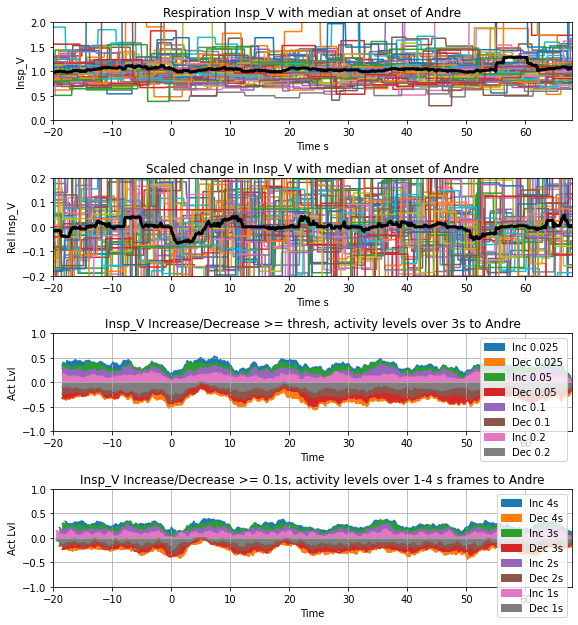

In [254]:
# changes in Period_T
fig = plt.figure(figsize=(9,8))
left, width = 0.1, 0.8
bottom, height = 0.1, 0.17
spacing = 0.1
thr = [0.025,0.05,0.1,0.2]
#thr = [0.05,0.1,0.2,0.4]
#thr = [0.1,0.2,0.3,0.5]
frm = [4,3,2,1]

subp = 0
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
# ax = fig.add_subplot(313)
for f in frm:
    FrameSize = f # seco#ds
    HopSize = 0.2 # seconds
    Thresh = thr[2]#Treshes[feat] # minimum
    AC1 = activityCount(featCont,FrameSize,HopSize,Thresh,'Inc') 
    AC2 = activityCount(featCont,FrameSize,HopSize,Thresh,'Dec')
    AC = pd.DataFrame()
    AC['Inc'+' '+str(f) + 's']=AC1['Total']
    AC['Dec'+' '+str(f) + 's']=-AC2['Total']
    AC.plot.area(ax=ax)

plt.grid()
plt.ylim(-1,1)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title(feat + ' Increase/Decrease >= ' + str(Thresh)+ 's, activity levels over 1-4 s frames to ' + stim)
plt.ylabel('Act Lvl')
plt.legend(loc='upper right')

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
# ax = fig.add_subplot(313)
for t in thr:
    FrameSize = 3 # seconds
    HopSize = 0.2 # seconds
    Thresh = t#Treshes[feat] # minimum
    AC1 = activityCount(featCont,FrameSize,HopSize,Thresh,'Inc') 
    AC2 = activityCount(featCont,FrameSize,HopSize,Thresh,'Dec')
    AC = pd.DataFrame()
    AC['Inc'+' '+str(t)]=AC1['Total']
    AC['Dec'+' '+str(t)]=-AC2['Total']
    AC.plot.area(ax=ax)

plt.grid()
plt.ylim(-1,1)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title(feat + ' Increase/Decrease >= thresh, activity levels over ' + str(FrameSize) + 's to ' + stim)
plt.ylabel('Act Lvl')
plt.legend(loc='upper right')

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
Shifted = featCont-featCont.median(0)
Shifted.plot(legend = False,ax=ax)
Shifted.median(1).plot(linewidth=3,color='k',ax=ax)
plt.ylim(-0.2,0.2)
plt.xlim(featCont.index[0],featCont.index[-1])
#plt.xlim(-15,15)
plt.title('Scaled change in ' + feat+ ' with median at onset of ' + stim)
plt.ylabel('Rel ' + feat)

subp +=1
ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
plt.title('Respiration ' + feat + ' with median at onset of ' + stim)
featCont.plot(legend = False,ax=ax)
featCont.mean(1).plot(linewidth=3,color='k')
plt.ylim(0,2)
plt.ylabel(feat)
plt.xlim(featCont.index[0],featCont.index[-1])
plt.savefig(stim+feat+'_timecours_al.png',dpi = 400)
plt.show()

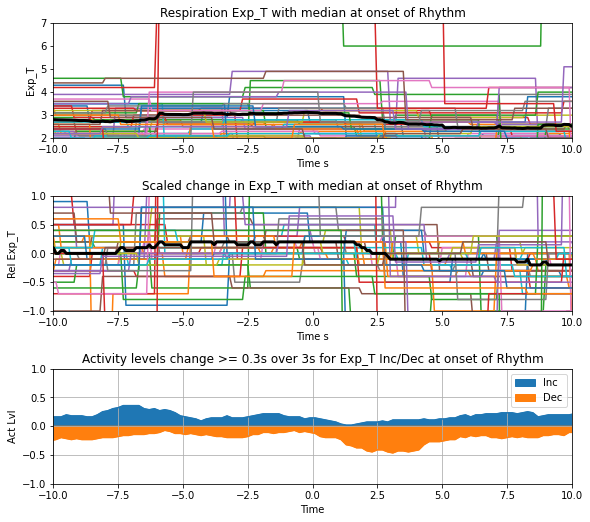

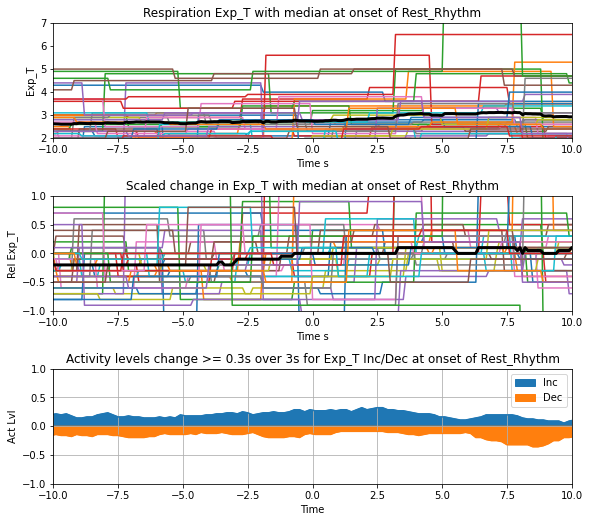

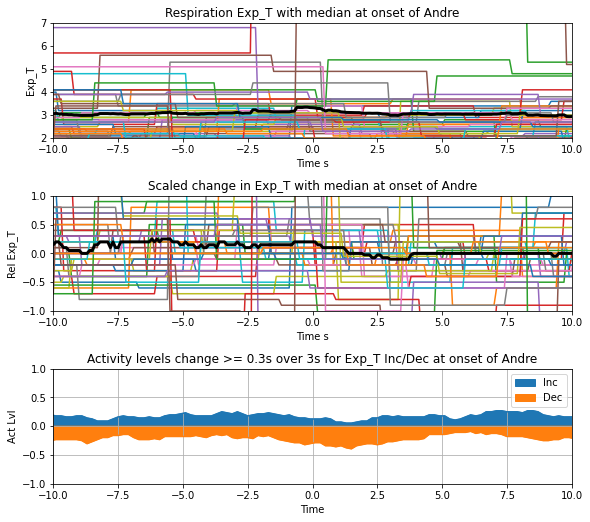

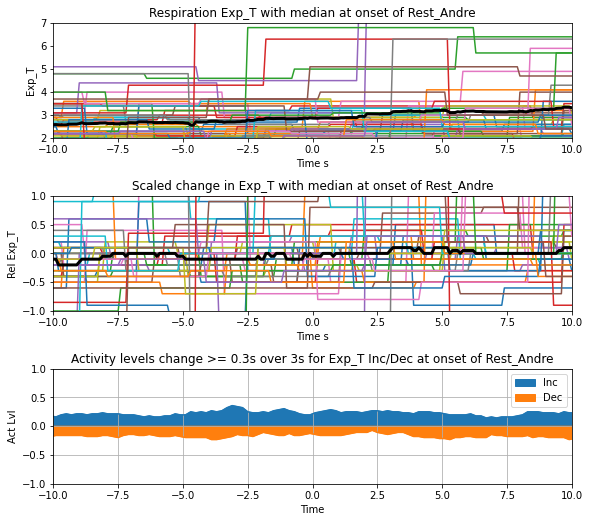

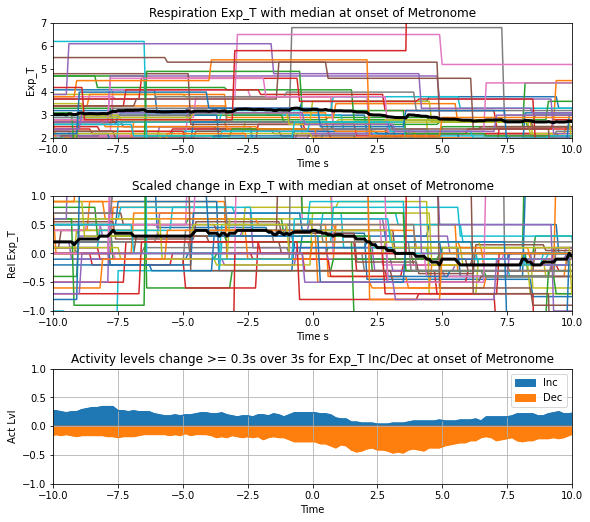

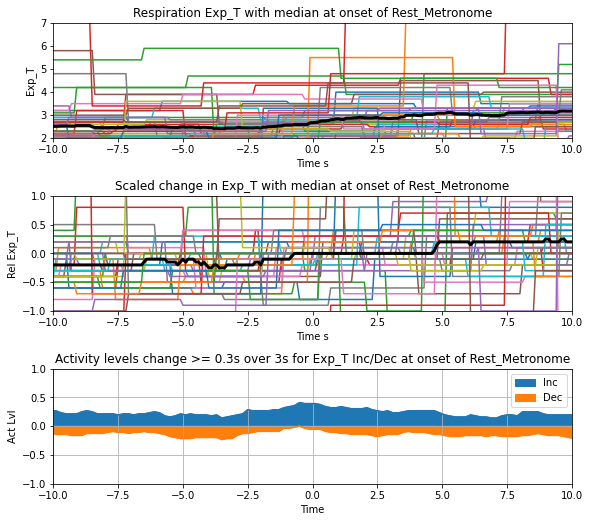

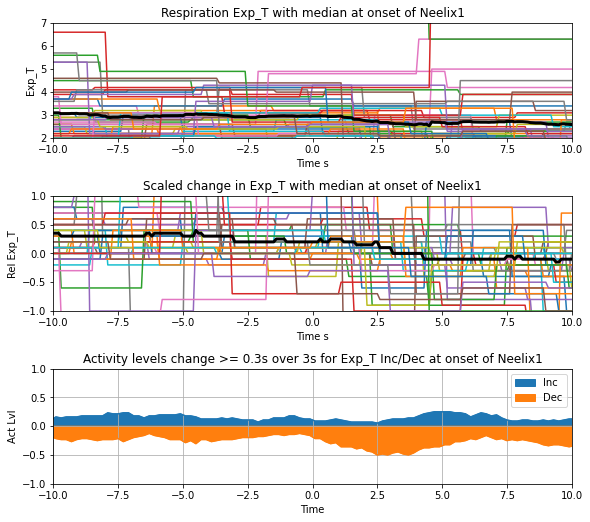

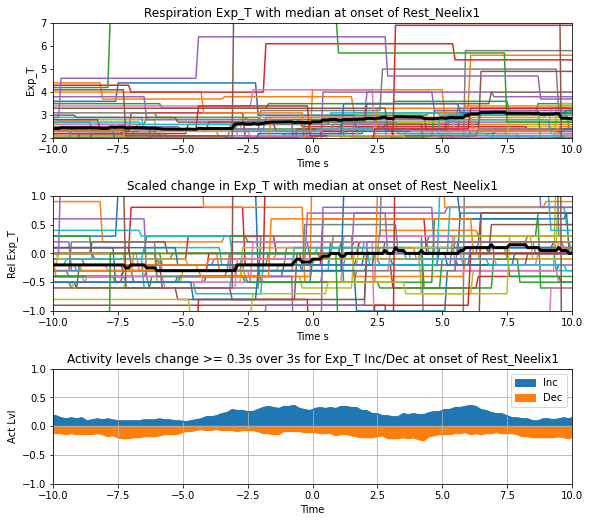

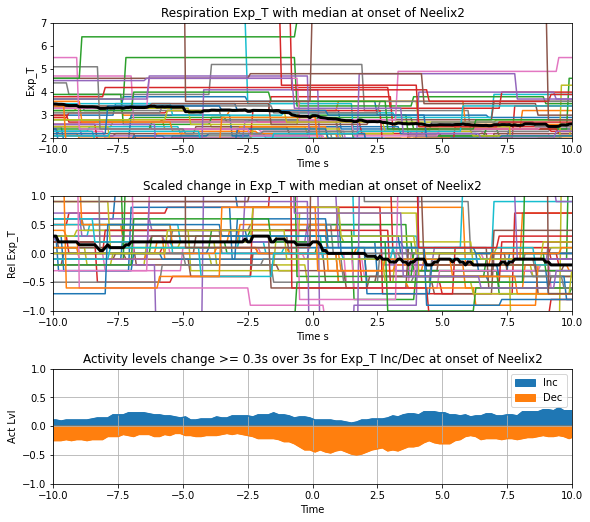

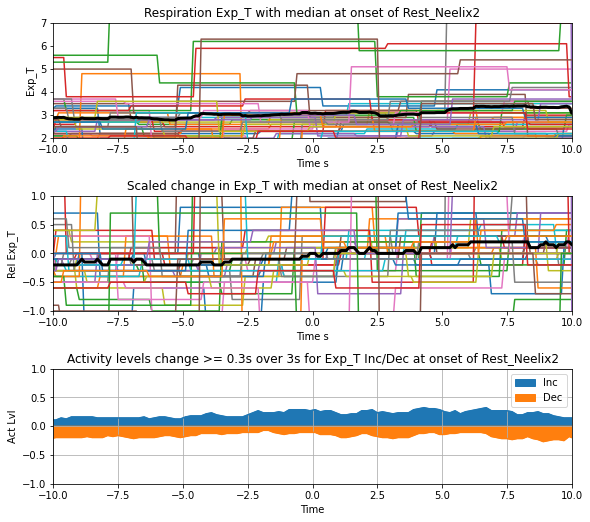

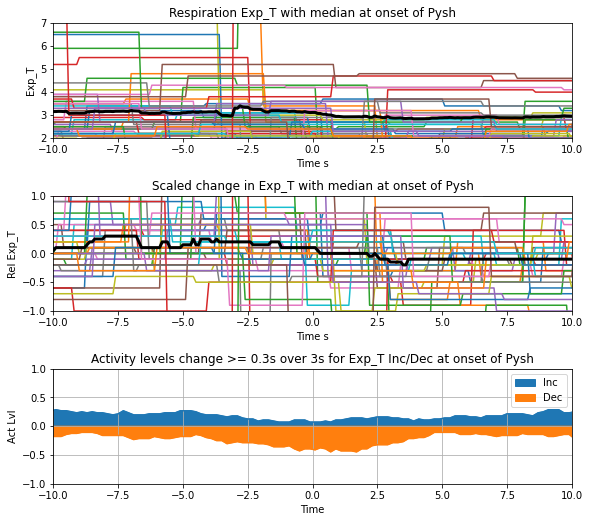

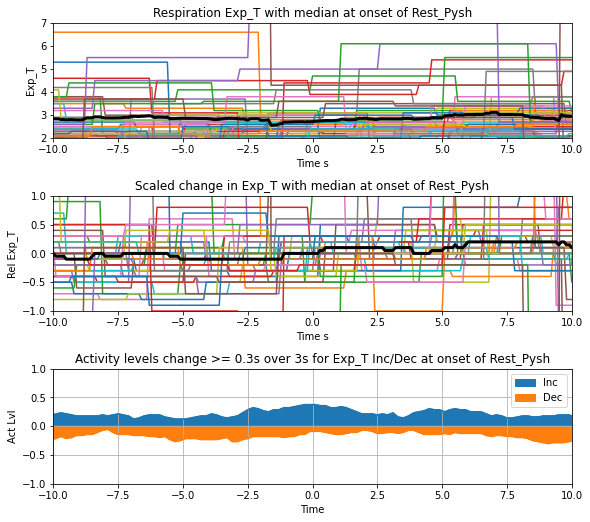

In [256]:
# evaluate timline of effects on stimuli 
stim_names = ['Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh']
Treshes = {'Period_T': 0.4,'Exp_T':0.3,'Insp_T':0.1}
buff =15
feat = 'Exp_T'
for stim in stim_names:
    featCont = pd.DataFrame()
    for part in participants:
        for sess in ['S1','S2']:
            sig = RespNorm.loc[:,idx[sess,part]]
            onsets = stimOnsets.loc[idx[part],idx[sess,:]]
            Breaths = respy.Breath_Continues_Features(sig,scaling=1,filtered=True,interp_style='previous')
            stim_on = onsets.loc[idx[sess],idx[stim]]
            if stim.startswith('Rest'):
                dur = 30
            else:
                dur = stimulus_dur[stim]
                sounding = 'On'
            v = Breaths.loc[stim_on-buff:stim_on+dur+buff,feat]
            v.index = np.round(v.index-stim_on,3)
            featCont[part + '_' + sess]=v
    # changes in Period_T
    fig = plt.figure(figsize=(9,8))
    left, width = 0.1, 0.8
    bottom, height = 0.1, 0.2
    spacing = 0.1

    subp = 0
    ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
    # ax = fig.add_subplot(313)
    FrameSize = 3 # seconds
    HopSize = 0.2 # seconds
    Thresh = Treshes[feat] # minimum
    AC1 = activityCount(featCont,FrameSize,HopSize,Thresh,'Inc') 
    AC2 = activityCount(featCont,FrameSize,HopSize,Thresh,'Dec')
    AC = pd.DataFrame()
    AC['Inc']=AC1['Total']
    AC['Dec']=-AC2['Total']

    AC.plot.area(ax=ax)
    plt.grid()
    plt.ylim(-1,1)
    plt.xlim(-10,10)
    plt.title('Activity levels change >= ' + str(Thresh) +'s over ' + str(FrameSize) + 's for ' + feat+ ' Inc/Dec at onset of ' + stim)
    plt.ylabel('Act Lvl')

    subp +=1
    ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
    Shifted = featCont-featCont.median(0)
    Shifted.plot(legend = False,ax=ax)
    Shifted.median(1).plot(linewidth=3,color='k',ax=ax)
    plt.ylim(-1,1)
    plt.xlim(-10,10)
    plt.title('Scaled change in ' + feat+ ' with median at onset of ' + stim)
    plt.ylabel('Rel ' + feat)

    subp +=1
    ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
    plt.title('Respiration ' + feat + ' with median at onset of ' + stim)
    featCont.plot(legend = False,ax=ax)
    featCont.mean(1).plot(linewidth=3,color='k')
    plt.ylim(2,7)
    plt.ylabel(feat)
    plt.xlim(-10,10)
    plt.savefig(stim+feat+'_onset_time.png',dpi = 400)
    #plt.show()

In [ ]:
# evaluate timline of effects on stimuli 
stim_names = ['Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh']
Treshes = {'Period_T': 0.4,'Exp_T':0.3,'Insp_T':0.1}
buff =15
feat = 'Insp_T'
for stim in stim_names:
    featCont = pd.DataFrame()
    for part in participants:
        for sess in ['S1','S2']:
            sig = RespNorm.loc[:,idx[sess,part]]
            onsets = stimOnsets.loc[idx[part],idx[sess,:]]
            Breaths = respy.Breath_Continues_Features(sig,scaling=1,filtered=True,interp_style='previous')
            stim_on = onsets.loc[idx[sess],idx[stim]]
            if stim.startswith('Rest'):
                dur = 30
            else:
                dur = stimulus_dur[stim]
                sounding = 'On'
            v = Breaths.loc[stim_on-buff:stim_on+dur+buff,feat]
            v.index = np.round(v.index-stim_on,3)
            featCont[part + '_' + sess]=v
    # changes in Period_T
    Treshes = {'Period_T': 0.5,'Exp_T':0.3,'Insp_T':0.1}
    fig = plt.figure(figsize=(9,8))
    left, width = 0.1, 0.8
    bottom, height = 0.1, 0.2
    spacing = 0.1

    subp = 0
    ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
    # ax = fig.add_subplot(313)
    FrameSize = 3 # seconds
    HopSize = 0.2 # seconds
    Thresh = Treshes[feat] # minimum
    AC1 = activityCount(featCont,FrameSize,HopSize,Thresh,'Inc') 
    AC2 = activityCount(featCont,FrameSize,HopSize,Thresh,'Dec')
    AC = pd.DataFrame()
    AC['Inc']=AC1['Total']
    AC['Dec']=-AC2['Total']

    AC.plot.area(ax=ax)
    plt.grid()
    plt.ylim(-1,1)
    plt.xlim(-10,10)
    plt.title('Activity levels change >= ' + str(Thresh) +'s over ' + str(FrameSize) + 's for ' + feat+ ' Inc/Dec at onset of ' + stim)
    plt.ylabel('Act Lvl')

    subp +=1
    ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
    Shifted = featCont-featCont.median(0)
    Shifted.plot(legend = False,ax=ax)
    Shifted.median(1).plot(linewidth=3,color='k',ax=ax)
    plt.ylim(-0.5,0.5)
    plt.xlim(-10,10)
    plt.title('Scaled change in ' + feat+ ' with median at onset of ' + stim)
    plt.ylabel('Rel ' + feat)

    subp +=1
    ax= fig.add_axes([left,bottom+subp*(height+ spacing),width,height])
    plt.title('Respiration ' + feat + ' with median at onset of ' + stim)
    featCont.plot(legend = False,ax=ax)
    featCont.mean(1).plot(linewidth=3,color='k')
    plt.ylim(0.5,2)
    plt.ylabel(feat)
    plt.xlim(-10,10)
    plt.savefig(stim+feat+'_onset_time.png',dpi = 400)
    #plt.show()

These results show that the change in respiratory features is nearly immediate: the first inspiration after the onset of sound shows a shorted period. Strong example: in Metronome, Period_T. The change with the onset of sound is strong for breath duration but deepth is not as consistent, with similar concentrations of devation (inc and dec) in moments during stimuli. (example Neelix 2)

Stimulus differences are 

# Phase alignment to stimuli

Did these stimuli encourage phase coordination across participants? Where the changes in respiratory behaviour in add of aligned respiratory action? 

Not likely, but we will check:

    1. Evaluate phase per breathe
    2. Evaluate alignment per phase with local activity test (aa)
    3. Consider coordination scores for all phases, across all stimuli (sound)

In [12]:
# start with one stimulus, respiration normalised

#Extract breaths

#extract phases (dictionary of dataframes)

#evaluate coordination with phase appropriate parameters

#results for this stimulus?

# old code snippets

In [ ]:
bfactors = ['Stimulus','Condition']

for col in defeats: 
    aov = pg.rm_anova(dv=col, within=bfactors,subject='Participant', data=subfeat)
    print('\n\n' + col + ' means for factors: ' + str(bfactors))
    print(aov)

# Stimulus differences in Phase durations (I p<.05,E p<.005,P p<.005) and Insp velocity (p<.05) p corrected

In [ ]:
for col in defeats:
    x = feat_means[feat_means['Stimulus']=='Andre'].loc[:,col]
    y = feat_means[feat_means['Stimulus']=='Neelix1'].loc[:,col]

    print([col,pg.compute_effsize(x, y, paired=True, eftype='cohen')])

In [ ]:
for col in defeats:
    x = feat_means[feat_means['Stimulus']=='Neelix1'].loc[:,col]
    y = feat_means[feat_means['Stimulus']=='Metronome'].loc[:,col]

    print([col,pg.compute_effsize(x, y, paired=True, eftype='cohen')])

In [ ]:
col = 'Period_T'
print(col)
fig= plt.figure(figsize=(4,5))

sns.set_style("whitegrid")
axes= fig.add_axes([0.1,0.15,0.8,0.75])
sns.violinplot(x='Sound', y=col,data=feat_means, 
                 width=1,palette="colorblind")#, order = mainCycle)
# axes.set_xbound(lower=-20, upper=20)
axes.set_ybound(lower=-0.5, upper=2)
plt.title('Median ' + col + ' sequential change (abs) with Sound')
plt.xlabel('Sound')
plt.ylabel(col)
plt.show()

pg.rm_anova(dv=col, within=['Sound','Condition'],
                  subject='Participant', data=feat_means, detailed=True,
                  effsize="ng2")

In [ ]:
col = 'Period_T'
print(col)
fig= plt.figure(figsize=(10,3))

sns.set_style("whitegrid")
axes= fig.add_axes([0.1,0.15,0.8,0.75])
sns.violinplot(x='Stimulus', y=col,data=feat_means, 
                 width=1,palette="colorblind")#, order = mainCycle)
# axes.set_xbound(lower=-20, upper=20)
axes.set_ybound(lower=-0.5, upper=2)
plt.title('Median ' + col + ' sequential change (abs) with Sound')
plt.xlabel('Time (s)')
plt.ylabel(col)
plt.show()

pg.rm_anova(dv=col, within=['Stimulus','Session'],
                  subject='Participant', data=feat_means, detailed=True,
                  effsize="ng2")

In [ ]:
col = 'Period (s)'
subfeat = feat_means[feat_means.Sound == 'On']
print(col)
fig= plt.figure(figsize=(10,3))

sns.set_style("whitegrid")
axes= fig.add_axes([0.1,0.15,0.8,0.75])
sns.violinplot(x='Stimulus', y=col,data=subfeat, 
                 width=1,palette="colorblind")#, order = mainCycle)
# axes.set_xbound(lower=-20, upper=20)
axes.set_ybound(lower=-0.5, upper=2)
plt.title('Median ' + col + ' sequential change (abs) with Sound')
plt.xlabel('Time (s)')
plt.ylabel(col)
plt.show()

pg.rm_anova(dv=col, within=['Stimulus','Session'],
                  subject='Participant', data=subfeat, detailed=True,
                  effsize="ng2")

# Breathwise patterns

In [17]:
# Breaths per 
#feat_means = pd.DataFrame(columns=['Stimulus', 'Sound', 'Participant', 'Session', 'Condition', 'Ex', 'Depth','Insp (s)', 'Period (s)', 'Exp (s)', 'IE Ratio', 'Insp V', 'Exp V'])
# Per recording, extract respirations, breath features, and save statistics with all conditions in new dataframe
stim_names = ['Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh']
buff = 10
heard_op = ['','Headphones','Speakers']

all_breaths = pd.DataFrame()

for part in participants:
    dets = stim_sequence.loc[part]
    con = dets['Hp_Sp_first_12']
    heard = dets['Hp/Sp first']
    for sess in ['S1','S2']:

        # signal, stimulus times, recording condtions
        sig = RespNorm.loc[:,idx[sess,part]]
        onsets = stimOnsets.loc[idx[part],idx[sess,:]]
        
        Breaths = respy.Breath_Features(sig,filtered=True)
        Breaths = Breaths.set_index('In')
        if sess == 'S2':
            con=3-con
            heard = heard_op[con]
            
        for stim in stim_names:
            stim_on = onsets.loc[idx[sess],idx[stim]]
            if stim.startswith('Rest'):
                dur = 30
                sounding = 'Off'
            else:
                #dur = 25
                dur = stimulus_dur[stim]
                sounding = 'On'
            v=[]
            v = Breaths.loc[stim_on-buff:stim_on+dur+buff].reset_index()
            v['In'] = v['In']-stim_on
            v['Participant']=part
            v['Stimulus']=stim
            v['Sound']=sounding
            v['Session']=sess
            v['Condition']=heard
            all_breaths =all_breaths.append(v,ignore_index=True)

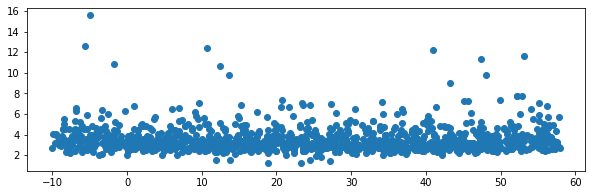

In [18]:
stim = 'Andre'
stim_breaths = all_breaths.loc[all_breaths['Stimulus']==stim]
fig= plt.figure(figsize=(10,3))

plt.scatter(stim_breaths['In'],stim_breaths['Period_T'])
plt.show()


In [ ]:
for col in defeats:
    fig= plt.figure(figsize=(10,3))
    for part in participants:
        part_breaths = stim_breaths.loc[stim_breaths['Participant']==part,:]
        for sess in ['S1','S2']:
            s_breaths = part_breaths.loc[part_breaths['Session']==sess]
            plt.plot(s_breaths.index,s_breaths[col])
            plt.title(col + ' ' + stim + ' ' + sess)